In [83]:
import formatData
import utils
import subprocess
import gdown
import modelBuilder
import os
import torch
import numpy as np
import pims
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [56]:
videoPath = "../data/OVSD/Big_buck_bunny.avi" # Put the path to your file here
shotThres = 0.1                               # The shot detection threshold. Higher will produce less shot

videoName = os.path.basename(os.path.splitext(videoPath)[0])

if not os.path.exists("{}_shotBounds.csv".format(videoName)):
    nbFrames = formatData.getNbFrames(videoPath)
    fps = utils.getVideoFPS(videoPath)

    #Detecting shots boundaries. This can be a bit long
    shotBounds = formatData.detect_format_shots(videoPath,shotThres,nbFrames,fps)
       
    #Saving shot boundaries
    np.savetxt("{}_shotBounds.csv".format(videoName),shotBounds)
else:
    shotBounds = np.genfromtxt("{}_shotBounds.csv".format(videoName))
    
keyFrameInds = shotBounds.mean(axis=1).astype(int)

In [4]:

if not os.path.exists("./modelres50_res50_epoch144"):
    subprocess.call("gdown https://drive.google.com/uc?id=1sN_7u7JuDOTgQ1c_R00qwAyEQEG1lnn9",shell=True)
    
model = modelBuilder.SceneDet(temp_model="resnet50",featModelName="resnet50",cuda=torch.cuda.is_available())

In [57]:
N = 10 #The model reads the first N shots at the same time, then the next N shots, etc.
imgSize = 299
decisionThres = 0.5 # If a shot score is above this threshold, it will be considered as a scene change

video = pims.Video(videoPath)

#This separates the frame indexes into several batches which size is close to N
split_keyFrameInds = np.array_split(keyFrameInds,len(keyFrameInds)//N+(len(keyFrameInds)%N != 0))

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preproc = transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(imgSize),transforms.ToTensor(),normalize])

#allScores = []

#for frameInds in split_keyFrameInds:
    
#    frameSeq = torch.cat(list(map(lambda x:preproc(video[x]).unsqueeze(0),np.array(frameInds))),dim=0).unsqueeze(0)
#    scores = model(frameSeq,None).data

#    allScores.append(scores.squeeze(0))
    
#scores = torch.cat(allScores,dim=0)    

scores = torch.zeros((len(shotBounds)))
scores[4] = 1
scores[82] = 1

sceneChange_shotIndex = (scores>decisionThres).nonzero().squeeze(1)
sceneChange_frameIndex = shotBounds[sceneChange_shotIndex][:,0]

np.savetxt("{}_sceneChange.csv".format(videoName),sceneChange_frameIndex)

In [38]:
!cat Big_buck_bunny_sceneChange.csv

1.144000000000000000e+03
4.699000000000000000e+03


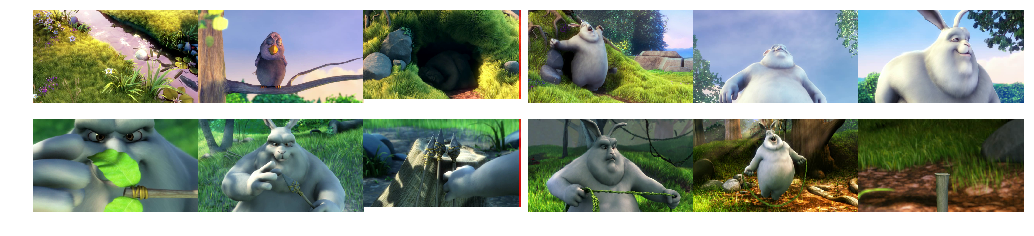

In [111]:
import sys


imgSize = 4
contextShots = 3
columns = 2*contextShots
rows = len(sceneChange_frameIndex)

frame = video[0]
ratio = frame.shape[1]/frame.shape[0] - 0.3

plt.figure(figsize=(imgSize*ratio*contextShots, imgSize))

gs1 = gridspec.GridSpec(rows, columns)
gs1.update(wspace=0.0, hspace=0.0)

for i in range(rows):

    for j in range(contextShots):
        precKeyFrameInd = shotBounds[sceneChange_shotIndex[i]+j-contextShots].mean().astype(int)
        plt.subplot(gs1[i*columns+j])
        plt.axis('off')
        plt.imshow(video[precKeyFrameInd])
       
    plt.vlines([video[precKeyFrameInd].shape[1]],0,video[precKeyFrameInd].shape[0],color="red")
    
    for j in range(contextShots):
        keyFrameInd = shotBounds[sceneChange_shotIndex[i]+j].mean().astype(int)
        plt.subplot(gs1[i*columns+j+contextShots])
        plt.axis('off')
        plt.imshow(video[keyFrameInd])

plt.show()